In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.interpolate import interp1d

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import tqdm
import time


from generators_stoch import *
from generators_wavelets import *
from utils import *
from solver import *

ModuleNotFoundError: No module named 'torch'

# Data generation

### Global parameters

In [4]:
Lx = 1
nx = 400    # number of grid points in the horizontal direction
nz = nx     # number of grid points in the vertical direction
dd = Lx/nx  # grid cell size
T = 1
nt = 800    # number of time samples to be modeled
dt = T/nt   # time step

nabs = 40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

vp = np.ones((nx,nz)) # Just simple identity field.
assert dt < dd/(np.sqrt(2.0)*np.max(vp)),'Courant not satisfied!' # making sure Courant number is fine

### Generating data and wave signal

In [6]:
def generate_sample(nx, nz, dd, nabs, a, nt, dt, vp, wav_type, FreeSurf=False):
    """
    Generate one sample of spatial-temporal series from FD solver.
    Input:
    nx, nz, nt - number of grid nodes and timesteps.
    nabs - size of sponging layer.
    a - sponging coeff.
    dd, dt - size of timesteps (in nondimensional units).
    wav_type - type of generated signal: 0/1/2 - Gauss/AR1/Wavelet.
    Output:
    (wvfld, wav).
    wvfld - field: np.ndarray with size (nx,nz,nt)
    wav - wave function: np.ndarray with size (nt,)
    """
    #
    wav_namespace = ['db3', 'db4', 'db5', 'db6', 'db7', 
                 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 
                 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 
                 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15',
                 'dmey']
    num_wavs = len(wav_namespace)
    print(num_wavs)
    #
    src = generate_source_coordinate(nx, nz, nabs)
    srcx = src[0] # source horizontal location in grid number
    srcz = src[1] # source vertical location in grid number
    #
    if wav_type == 0:
        print('Generated gaussian wave.')
        r_corr = nt/20
        wav = generate_stoch_gauss(nt, r_corr)
        wav = wav - wav[0]
    elif wav_type == 1:
        print('Generated AR1 wave.')
        wav = generate_stoch_ar1(nt, -0.99)
        wav = wav - wav[0]
    elif wav_type == 2:
        kk = np.random.randint(0, 2)
        k = np.random.randint(0, num_wavs)
        print('Generated wavelet {}, {}.'.format(wav_namespace[k], kk))
        wav_tuple = generate_wavelets(nt, wav_namespace[k])
        wav = wav_tuple[kk]
        wav[0] = 0
    else:
        raise ValueError('Wav_type is incorrect. Allowed values = 0/1/2')

    wvfld = fd_ac(vp,dd,dt,srcx,srcz,wav,nabs,a,FreeSurf)
    #wvfld = wvfld[nabs:-nabs, nabs:-nabs, :] # Cut of sponging nodes
    #
    return wvfld, wav

def generate_batch():
    """
    Generate one batch for training.
    We generate one random Gauss signal, one random AR1 signal, and one random wavelet.
    """
    dataset = []
    waves = []
    for i in range(3):
        data, wave = generate_sample(nx, nz, dd, nabs, a, nt, dt, vp, i, FreeSurf=False)
        dataset.append(data)
        waves.append(wave)

    dataset = np.stack(dataset, axis=0)
    return dataset, waves

# Network

In [7]:
# We use "standard" convolutional neural network called "U-Net".
# from Fotiadis et al, 2020.
# With some custom improvements.

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, num_input_frames, num_output_frames, isize):
        super().__init__()
        self.num_input_frames = num_input_frames
        self.num_output_frames = num_output_frames
        self.dconv_down1 = double_conv(num_input_frames, isize)
        self.dconv_down2 = double_conv(isize, isize*2)
        self.dconv_down3 = double_conv(isize*2, isize*4)
        self.dconv_down4 = double_conv(isize*4, isize*8)

        self.maxpool = nn.MaxPool2d(2)
        # self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.upsample = lambda x: torch.nn.functional.interpolate(x, mode='bilinear', scale_factor=2, align_corners=True)

        self.dconv_up3 = double_conv(isize*4 + isize*8, isize*4)
        self.dconv_up2 = double_conv(isize*2 + isize*4, isize*2)
        self.dconv_up1 = double_conv(isize*2 + isize, isize)

        self.conv_last = nn.Conv2d(isize, num_output_frames, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

    def get_future_frames(self, input_frames, num_total_output_frames, refeed):
        output_frames = self(input_frames)
        num_input_frames = self.get_num_input_frames()

        while output_frames.size(1) < num_total_output_frames:
            if output_frames.size(1) < num_input_frames:
                keep_from_input = num_input_frames - output_frames.size(1)
                input_frames = torch.cat((input_frames[:, -keep_from_input:, :, :], output_frames), dim=1)
            else:
                input_frames = output_frames[:, -num_input_frames:, :, :].clone()
            output_frames = torch.cat((output_frames, self(input_frames)), dim=1)
        return output_frames[:, :num_total_output_frames, :, :]

    def get_num_input_frames(self):
        return self.num_input_frames

    def get_num_output_frames(self):
        return self.num_output_frames

In [8]:
# Initializing Model.

device = get_device()

model = UNet(5, 1, 64)
model.to(device);

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

### Training

In [ ]:
n_epochs=100
max_n_skip = 10
# n_skip=3

save_model = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                                lr=1e-3)
losses = []

for epoch in range(46, n_epochs):
    t0 = time.time()
    print('Generating data...')

    dataset, waves = get_dataset()
    for ii in range(dataset.shape[0]):
        # dataset[ii] -= dataset[ii].mean()
        dataset[ii] /= np.abs(dataset[ii]).max()

    order_time = np.arange(dataset.shape[-1] - 6*max_n_skip - 1)

    print('Epoch {}'.format(epoch))

    #training
    for i in range(dataset.shape[-1] - 6*max_n_skip - 1):
        n_skip = np.random.randint(1, max_n_skip)
        np.random.shuffle(order_time)

        start_idx = order_time[i]
        indices = [start_idx + n_skip*i for i in range(6)]

        input_data = torch.from_numpy(dataset[..., indices[:5]]).float()
        input_data = torch.movedim(input_data, -1, 1)
        input_data = input_data.cuda()
        input_data = Variable(input_data)

        target = torch.from_numpy(dataset[..., indices[5:]]).float()
        target = torch.movedim(target, -1, 1)
        target = target.cuda()
        target = Variable(target)

        output = model(input_data)

        with torch.no_grad():
            l1 = F.mse_loss(output[0], target[0]).item()
            l2 = F.mse_loss(output[1], target[1]).item()
            l3 = F.mse_loss(output[2], target[2]).item()

        loss = F.mse_loss(output, target)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('\r[{}]: loss = {:.8}\n\tl1 = {:.8},\n\tl2 = {:.8},\n\tl3 = {:.8}'.format(i, losses[-1], l1, l2, l3), end='')
    print()
    print('Elapsed time: {} minutes', (time.time() - t0)/60)

    is save_model:
        if epoch % 5 == 0:
            torch.save(model.state_dict(), './saved_models/model_{}_epoch.pth'.format(epoch))

    del dataset
    del waves

### Saving model

In [14]:
torch.save(model.state_dict(), 'model_good.pth')

### Loading saved model

In [13]:
model.load_state_dict(torch.load('model_training_45.pth'))

<All keys matched successfully>

# Visualization

### Checking loss decrease

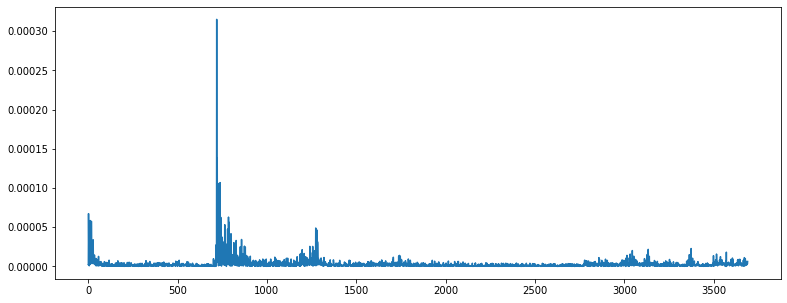

In [90]:
plt.figure(figsize=(13, 5))
plt.plot(losses)
plt.show()

### Prediction analysis

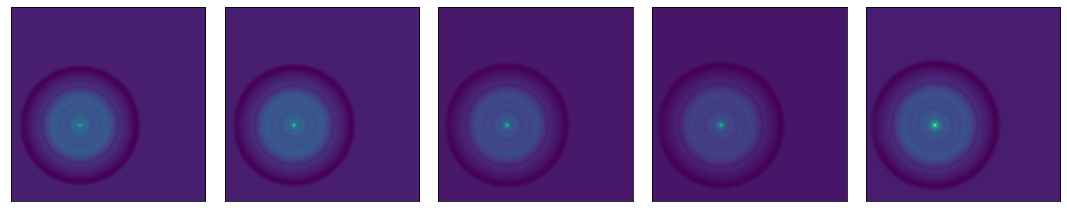

In [91]:
plot_seq(to_numpy(input_data)[1])

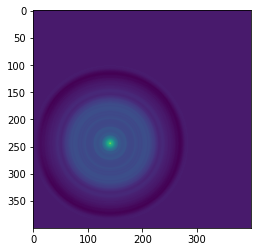

In [92]:
plot_seq(to_numpy(target)[1])

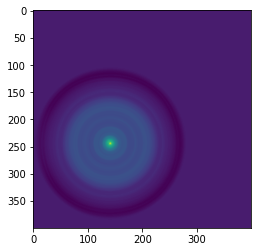

In [93]:
plot_seq(to_numpy(output)[1])

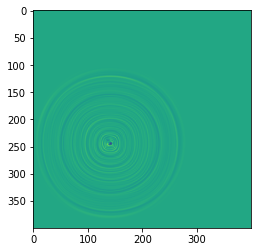

In [94]:
plot_seq(to_numpy(target - output)[1])

#### Slice of the predicted frame and target frame

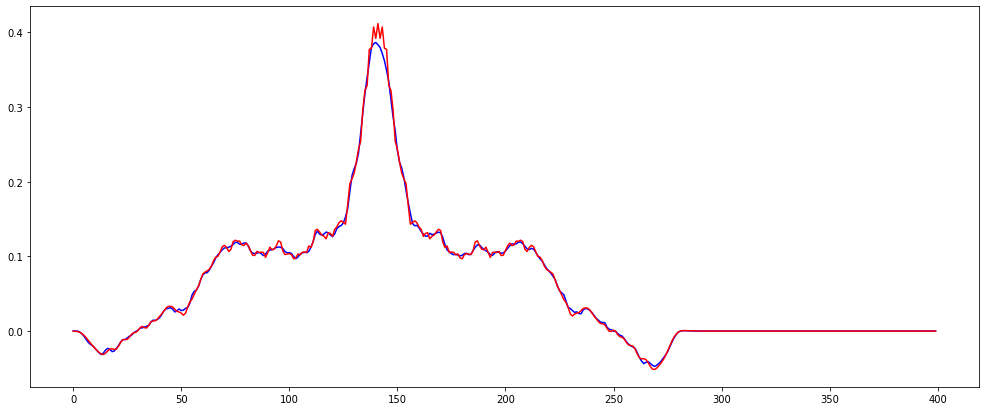

In [96]:
plt.figure(figsize=(17, 7))
plt.plot(to_numpy(output)[1, 240, : , 0], c='b')
plt.plot(to_numpy(target)[1, 240, : , 0], c='r')
plt.show()